# testing saveat adaptive step

- Pythagorean three-body problem example (Github)
- At Last section, integrations using saveat option 

## Loading packages

In [1]:
using IRKGaussLegendre
using OrdinaryDiffEq
using Plots, LinearAlgebra, LaTeXStrings
using BenchmarkTools

## Step 1: Defining the Problem
To solve this numerically, we define a problem type by giving it the equation, the initial condition, and the timespan to solve over:

In [2]:
function NbodyODE!(F,u,Gm,t)
     N = length(Gm)
     for i in 1:N
        for k in 1:3
            F[k, i, 2] = 0
        end
     end
     for i in 1:N
        xi = u[1,i,1]
        yi = u[2,i,1]
        zi = u[3,i,1]
        Gmi = Gm[i]
        for j in i+1:N
            xij = xi - u[1,j,1]
            yij = yi - u[2,j,1]
            zij = zi - u[3,j,1]
            Gmj = Gm[j]
            dotij = (xij*xij+yij*yij+zij*zij)
            auxij = 1/(sqrt(dotij)*dotij)
            Gmjauxij = Gmj*auxij
            F[1,i,2] -= Gmjauxij*xij
            F[2,i,2] -= Gmjauxij*yij
            F[3,i,2] -= Gmjauxij*zij
            Gmiauxij = Gmi*auxij
            F[1,j,2] += Gmiauxij*xij
            F[2,j,2] += Gmiauxij*yij
            F[3,j,2] += Gmiauxij*zij
        end
     end
     for i in 1:3, j in 1:N
        F[i,j,1] = u[i,j,2]
     end
    return nothing
end

NbodyODE! (generic function with 1 method)

In [3]:
Gm = [5, 4, 3]
N=length(Gm)
q=[1,-1,0,-2,-1,0,1,3,0]
v=zeros(size(q))
q0 = reshape(q,3,:)
v0 = reshape(v,3,:)
u0 = Array{Float64}(undef,3,N,2)
u0[:,:,1] = q0
u0[:,:,2] = v0
tspan = (0.0,63.0)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

## Step 2: Solving the problem
After defining a problem, you solve it using solve

### Seq implementation

In [4]:
sol1=solve(prob,IRKGL16(simd=false, second_order_ode=true),adaptive=true, reltol=1e-14, abstol=1e-14)
sol1.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  62336
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           7792
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          1357
Number of rejected steps:                          197

In [5]:
@btime solve(prob,IRKGL16(simd=false, second_order_ode=true),adaptive=true,
                          reltol=1e-14, abstol=1e-14, save_everystep=false);

  15.707 ms (4785 allocations: 1.88 MiB)


### SIMD-vectorized implementation 

- **~6 x faster than generic implementation !!**
- **Faster than DPRKN12 !!**


In [6]:
sol2=solve(prob,IRKGL16(simd=true, fseq=false, second_order_ode=true),adaptive=true, reltol=1e-14, abstol=1e-14)
sol2.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  61448
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           7681
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          1356
Number of rejected steps:                          185

In [7]:
#@btime solve(prob,IRKGL16(simd=true, fseq=false, second_order_ode=true),adaptive=true, 
#                          reltol=1e-14, abstol=1e-14, save_everystep=false);

### Hybrid implementation 

In [8]:
sol2b=solve(prob,IRKGL16(second_order_ode=true),adaptive=true, reltol=1e-14, abstol=1e-14)
sol2b.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  61448
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           7681
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          1356
Number of rejected steps:                          185

In [9]:
#@btime solve(prob,IRKGL16(second_order_ode=true),adaptive=true, 
#reltol=1e-14, abstol=1e-14, save_everystep=false);

### DPRKN12

In [10]:
function NbodyODE2nd!(ddu,du,u,Gm,t)

     N = length(Gm)

     for i in 1:N
         for k in 1:3
             ddu[k,i]= 0
         end
     end

     for i in 1:N
        xi = u[1,i]
        yi = u[2,i]
        zi = u[3,i]
        Gmi = Gm[i]
        for j in (i+1):N
           xij = xi - u[1,j]
           yij = yi - u[2,j]
           zij = zi - u[3,j]
           Gmj = Gm[j]
           dotij = (xij*xij+yij*yij+zij*zij)
           auxij = 1/(sqrt(dotij)*dotij)
           Gmjauxij = Gmj*auxij
           ddu[1,i] -= Gmjauxij*xij
           ddu[2,i] -= Gmjauxij*yij
           ddu[3,i] -= Gmjauxij*zij
           Gmiauxij = Gmi*auxij
           ddu[1,j] += Gmiauxij*xij
           ddu[2,j] += Gmiauxij*yij
           ddu[3,j] += Gmiauxij*zij
        end
     end

    return nothing

end

NbodyODE2nd! (generic function with 1 method)

In [11]:
q0=u0[:,:,1]
v0=u0[:,:,2]
prob2nd = SecondOrderODEProblem(NbodyODE2nd!,v0,q0,tspan,Gm)
sol3 =solve(prob2nd,DPRKN12(),abstol=1e-14,reltol=1e-14)
sol3.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  77353
Number of function 2 evaluations:                  4551
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           0
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          3851
Number of rejected steps:                          699

In [12]:
#@btime solve(prob2nd,DPRKN12(),abstol=1e-14,reltol=1e-14, save_everystep=false);

**Convert solution data** to u0 format

In [13]:
nk=length(sol3.t)
etype=eltype(u0)
sol3u=Vector{Array{etype, 3}}(undef,nk)
sol3t=Vector{etype}(undef,nk)
uk=copy(u0)

for k in 1:nk
    uk[:,:,1]=sol3.u[k].x[2]
    uk[:,:,2]=sol3.u[k].x[1]
    sol3u[k]=copy(uk)
    sol3t[k]=sol3.t[k]
end

### Orbits

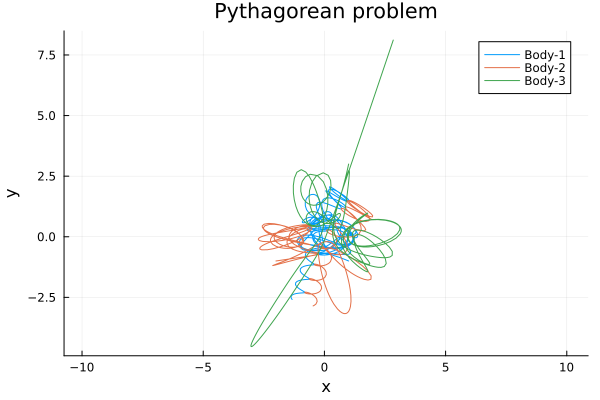

In [14]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Pythagorean problem",xlabel="x", ylabel="y",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[1,j,1], ulist1)
 ylist  = map(u->u[2,j,1], ulist1)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  
plot(pl)

### Step size

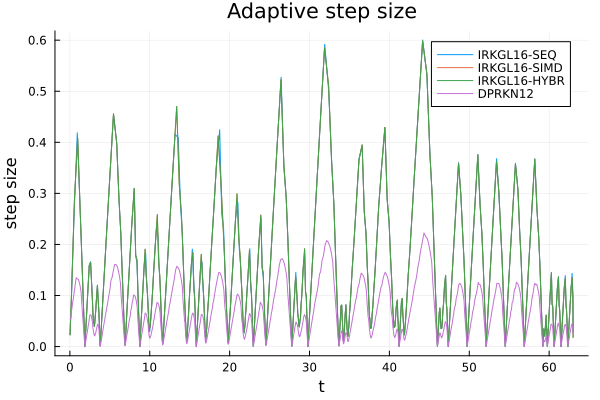

In [15]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot!(sol1.t[2:end],steps1, label="IRKGL16-SEQ")
steps2 =sol2.t[2:end]-sol2.t[1:end-1]
plot!(sol2.t[2:end],steps2, label="IRKGL16-SIMD")
steps2b =sol2b.t[2:end]-sol2b.t[1:end-1]
plot!(sol2b.t[2:end],steps2b, label="IRKGL16-HYBR")
steps3 =sol3.t[2:end]-sol3.t[1:end-1]
plot!(sol3.t[2:end],steps3, label="DPRKN12")

### Energy-Error

In [16]:
function NbodyEnergy(u,Gm)
     N = length(Gm)
     zerouel = zero(eltype(u))
     T = zerouel
     U = zerouel
     for i in 1:N
        qi = u[:,i,1]
        vi = u[:,i,2]
        Gmi = Gm[i]
        T += Gmi*(vi[1]*vi[1]+vi[2]*vi[2]+vi[3]*vi[3])
        for j in (i+1):N
           qj = u[:,j,1]
           Gmj = Gm[j]
           qij = qi - qj
           U -= Gmi*Gmj/norm(qij)
        end
     end
    1/2*T + U
end

NbodyEnergy (generic function with 1 method)

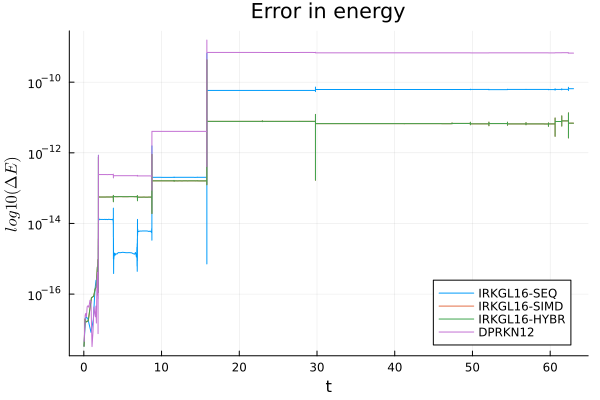

In [17]:
setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

E0=NbodyEnergy(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),GmBig), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),GmBig), sol2.u)./E0.-1
ΔE2b = map(x->NbodyEnergy(BigFloat.(x),GmBig), sol2b.u)./E0.-1
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),GmBig), sol3u)./E0.-1
plot(title="Error in energy", legend=:bottomright,
     xlabel="t", ylabel=L"log10(\Delta E)")
plot!(sol1.t[2:end], abs.(ΔE1[2:end]), yscale=:log10, label="IRKGL16-SEQ")
plot!(sol2.t[2:end], abs.(ΔE2[2:end]), yscale=:log10, label="IRKGL16-SIMD")
plot!(sol2b.t[2:end], abs.(ΔE2b[2:end]), yscale=:log10, label="IRKGL16-HYBR")
plot!(sol3t[2:end], abs.(ΔE3[2:end]), yscale=:log10, label="DPRKN12")

### Integrations using saveat

In [18]:
sol1_b=solve(prob,IRKGL16(simd=false, second_order_ode=true),adaptive=true, saveat=0.05, reltol=1e-14, abstol=1e-14)
length(sol1_b)

sol2_b=solve(prob,IRKGL16(simd=true, fseq=false,second_order_ode=true),adaptive=true, saveat=0.05, reltol=1e-14, abstol=1e-14)
length(sol2_b)

sol2_c=solve(prob,IRKGL16( second_order_ode=true),adaptive=true, saveat=0.05, reltol=1e-14, abstol=1e-14)
length(sol2_c)

1261

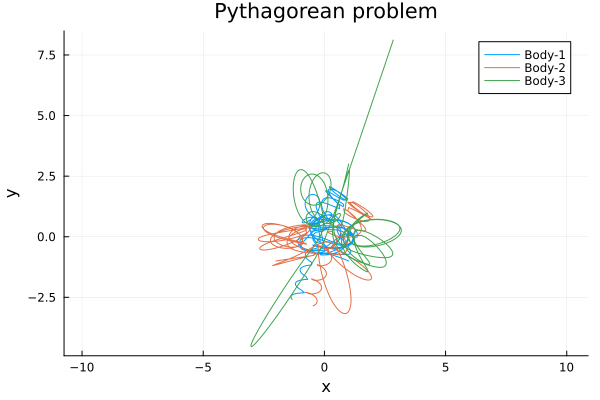

In [19]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Pythagorean problem",xlabel="x", ylabel="y",aspect_ratio=1)

ulist1 = sol1_b.u[1:end]
tlist1 = sol1_b.t[1:end]

for j = 1:3
 xlist  = map(u->u[1,j,1], ulist1)
 ylist  = map(u->u[2,j,1], ulist1)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  
plot(pl)

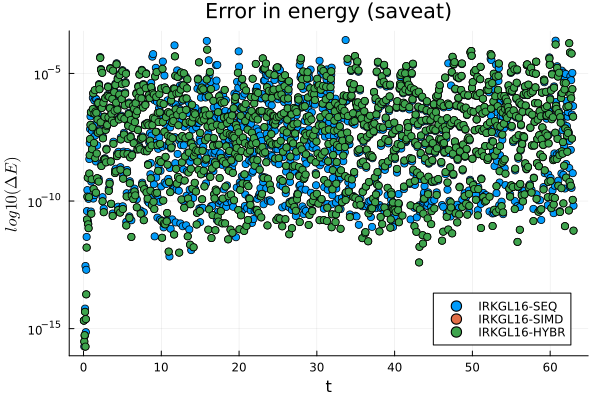

In [20]:
setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

E0=NbodyEnergy(u0Big,GmBig)
ΔE1_b = map(x->NbodyEnergy(BigFloat.(x),GmBig), sol1_b.u)./E0.-1
ΔE2_b = map(x->NbodyEnergy(BigFloat.(x),GmBig), sol2_b.u)./E0.-1
ΔE2_c = map(x->NbodyEnergy(BigFloat.(x),GmBig), sol2_c.u)./E0.-1
plot(title="Error in energy (saveat)", legend=:bottomright,
     xlabel="t", ylabel=L"log10(\Delta E)")
scatter!(sol1_b.t[2:end], abs.(ΔE1_b[2:end]), yscale=:log10, label="IRKGL16-SEQ")
scatter!(sol2_b.t[2:end], abs.(ΔE2_b[2:end]), yscale=:log10, label="IRKGL16-SIMD")
scatter!(sol2_c.t[2:end], abs.(ΔE2_c[2:end]), yscale=:log10, label="IRKGL16-HYBR")